In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 27, 2024
Last modified on May 30, 2024
@Author: Guan-Fu Liu

To compare the result from galIMF and ChemEvoIMF
"""
from read_results import *
import re
from matplotlib.gridspec import GridSpec
%matplotlib widget

In [2]:
file_path = "./outputs/ChemEvo_galIMF_set.h5"
yield_files, groups, ElemNotice, dfs, ElemIntersect, SNIaOn, mass_lifeAge_file, mass_lifeAge, SFH, StarInitElement,\
             StellarMass, SNccNum, SNIaNum, AGB_Num, GasElement, ZGas, EjectElement, SNccElement, SNIaElement,\
             AGB_Element, YieldsTable, IMF_type, IMF_data, creation_Age, SFE, \
             interp_kind, comments, solar_set = read_results(file_path)

The elements you notice but not available in the yield table of SNIa, Z=0.02 are
 {'Ca', 'He', 'H', 'C', 'N'}
The yields from SNIa are taken into consideration in the result to be analysed.


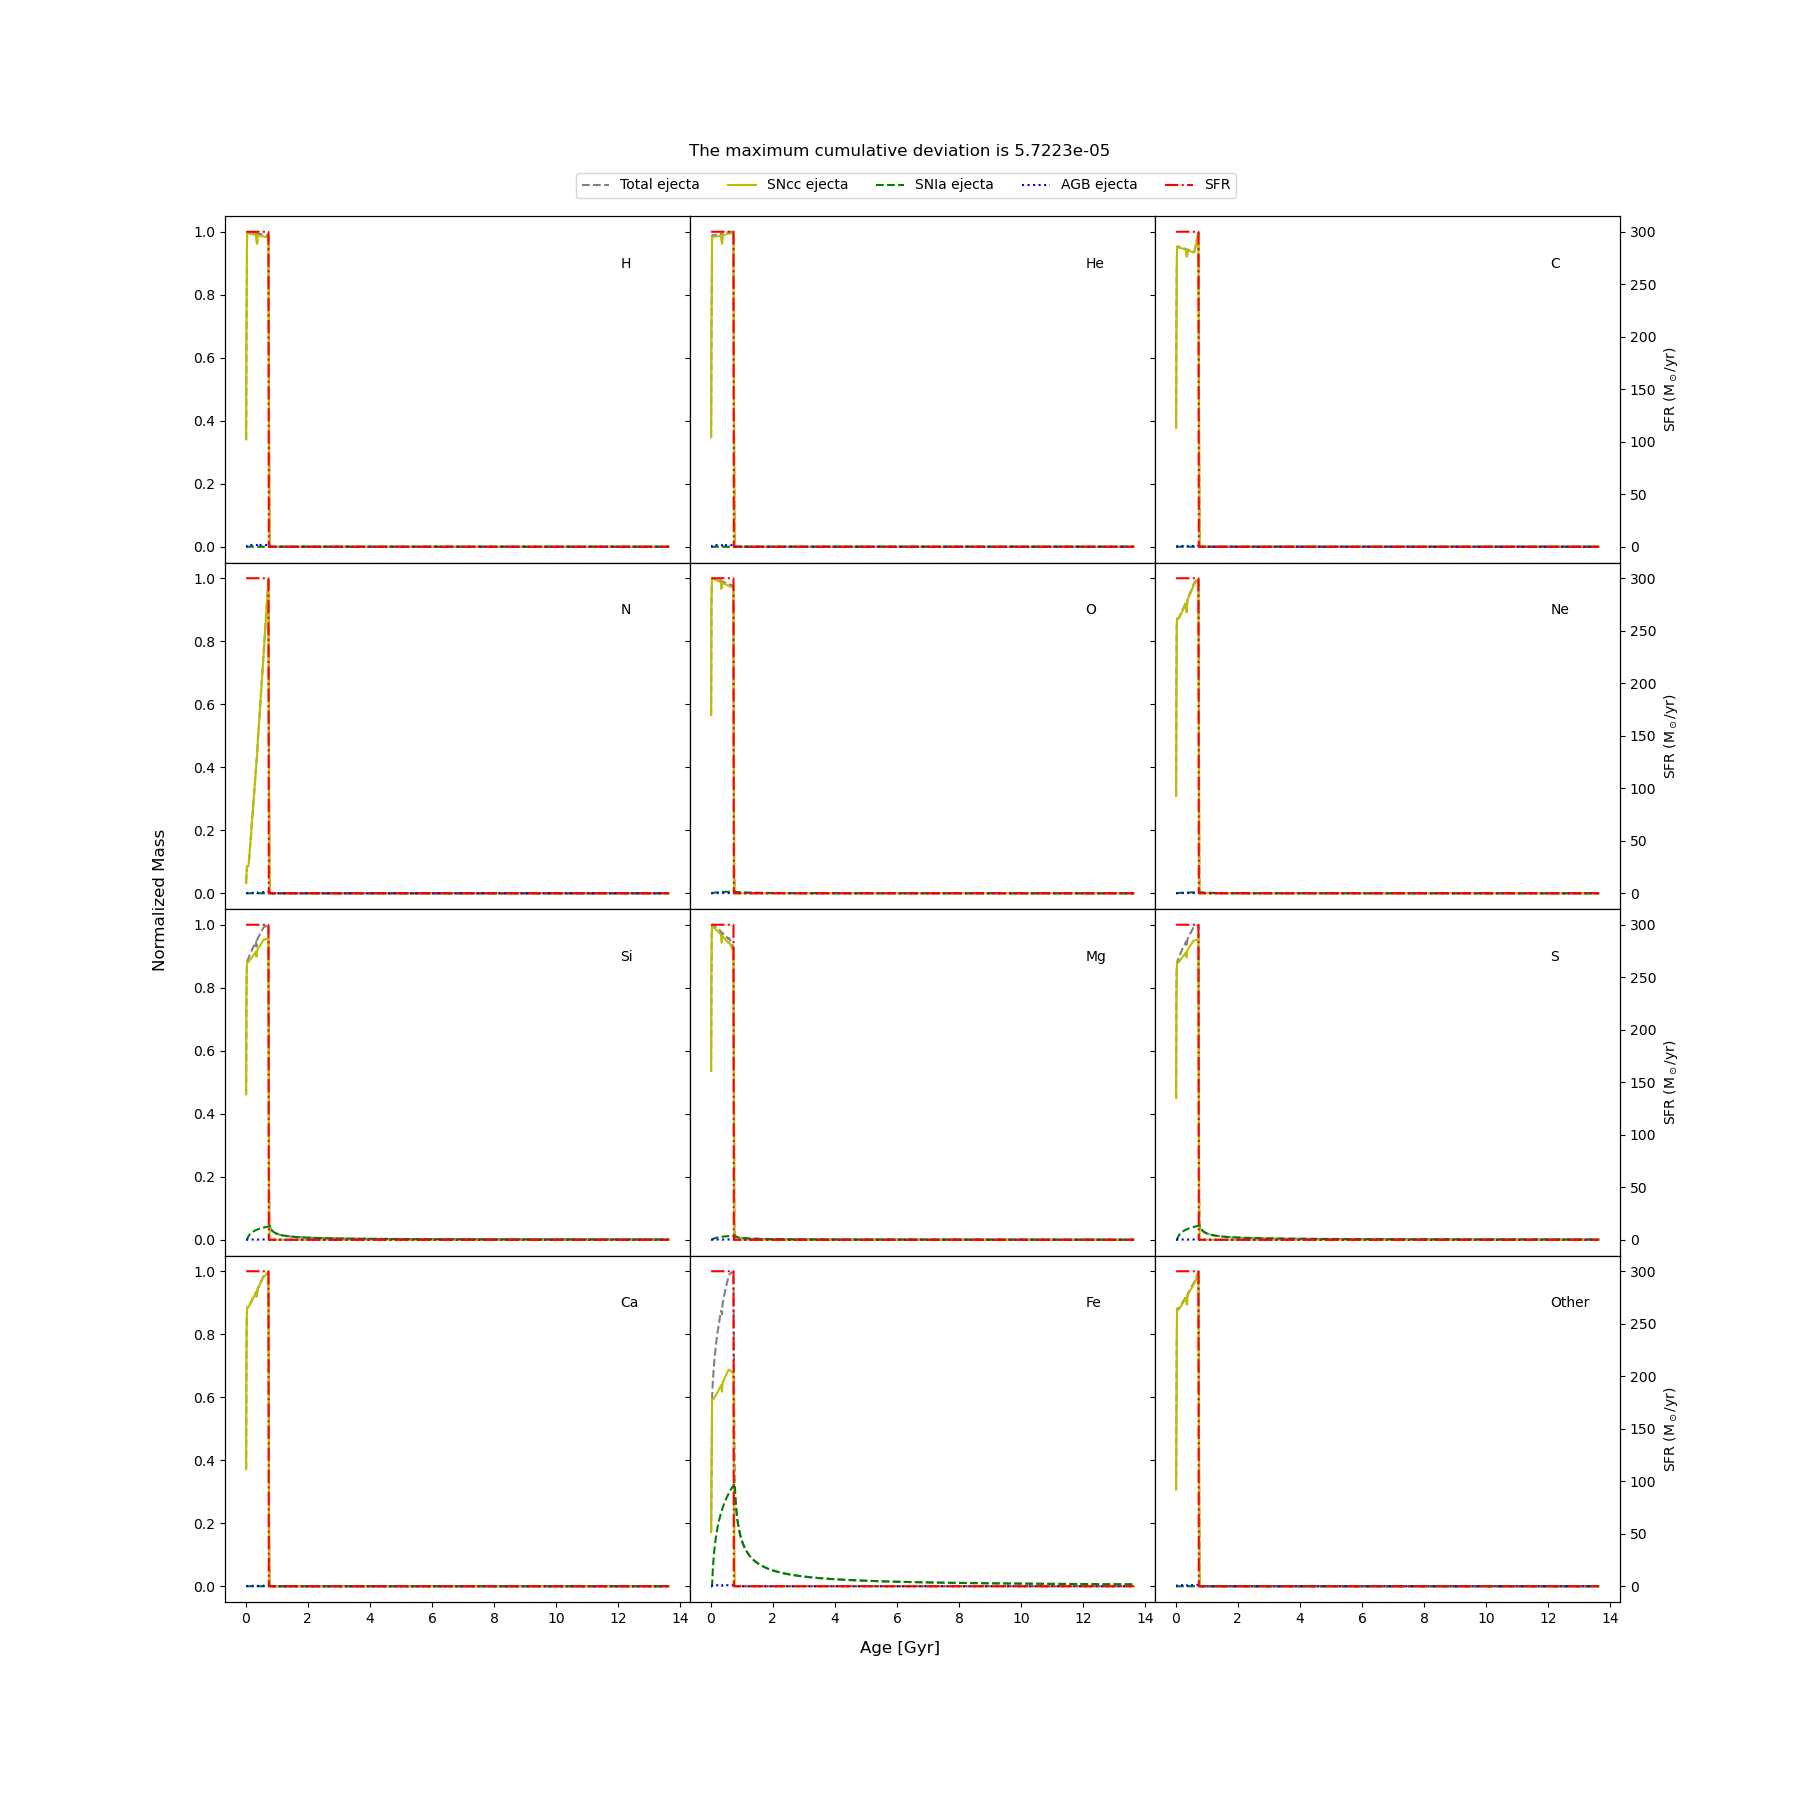

0.00043142655093700804 5.7222630307884095e-05


In [3]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
axes = { }
for i, elem in enumerate(ElemNotice):
    axes[elem] = fig.add_subplot(gs[i//3, i%3])
    norm = EjectElement[:, constants.elem_names.index(elem)].max()
    line1, = axes[elem].plot(SFH['Age']/1e9, EjectElement[:, constants.elem_names.index(elem)]/norm,
                              '--', color='grey', markersize=4, label="Total ejecta")
    line2, = axes[elem].plot(SFH['Age']/1e9, SNccElement[:, constants.elem_names.index(elem)]/norm,
                              'y-', markersize=4, label="SNcc ejecta")
    line3, = axes[elem].plot(SFH['Age']/1e9, SNIaElement[:, constants.elem_names.index(elem)]/norm,
                              'g--', markersize=4, label="SNIa ejecta")
    line4, = axes[elem].plot(SFH['Age']/1e9, AGB_Element[:, constants.elem_names.index(elem)]/norm,
                              'b:', markersize=4, label="AGB ejecta")

    # axes[elem].set_xscale('log')
    # axes[elem].set_yscale('log')
    # axes[elem].set_xlim(1e-2, 13.8)
    # axes[elem].set_ylim(1e-5, 1.5)
    if i not in [9, 10, 11]:
        axes[elem].set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        axes[elem].set_yticklabels([])
    axes[elem].annotate(elem, xy=(0.85, 0.85), xycoords='axes fraction')
    
    
    ax1 = axes[elem].twinx()
    line5, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])

fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel(r"Normalized Mass", x=0.085)
fig.legend((line1, line2, line3, line4, line5), ("Total ejecta", "SNcc ejecta", "SNIa ejecta", "AGB ejecta", "SFR"), loc=(0.32, 0.89), ncol=5)
deviation = np.abs(EjectElement.cumsum(axis=0)-SNccElement.cumsum(axis=0)-AGB_Element.cumsum(axis=0)-SNIaElement.cumsum(axis=0))
mask = EjectElement>0
deviation = deviation[mask]
deviation = deviation / EjectElement.cumsum(axis=0)[mask]
deviation = deviation.max()
fig.suptitle("The maximum cumulative deviation is %0.4e" % deviation, y=0.92)
# fig.suptitle("The evolution of the normalized instantaneous ejected mass", y=0.92)
fig.savefig("Instantaneous-ejecta-N13.pdf", dpi=300)
plt.show()
mask = EjectElement>0
print(np.abs((EjectElement-SNccElement-AGB_Element-SNIaElement)[mask]/EjectElement[mask]).max(), deviation)

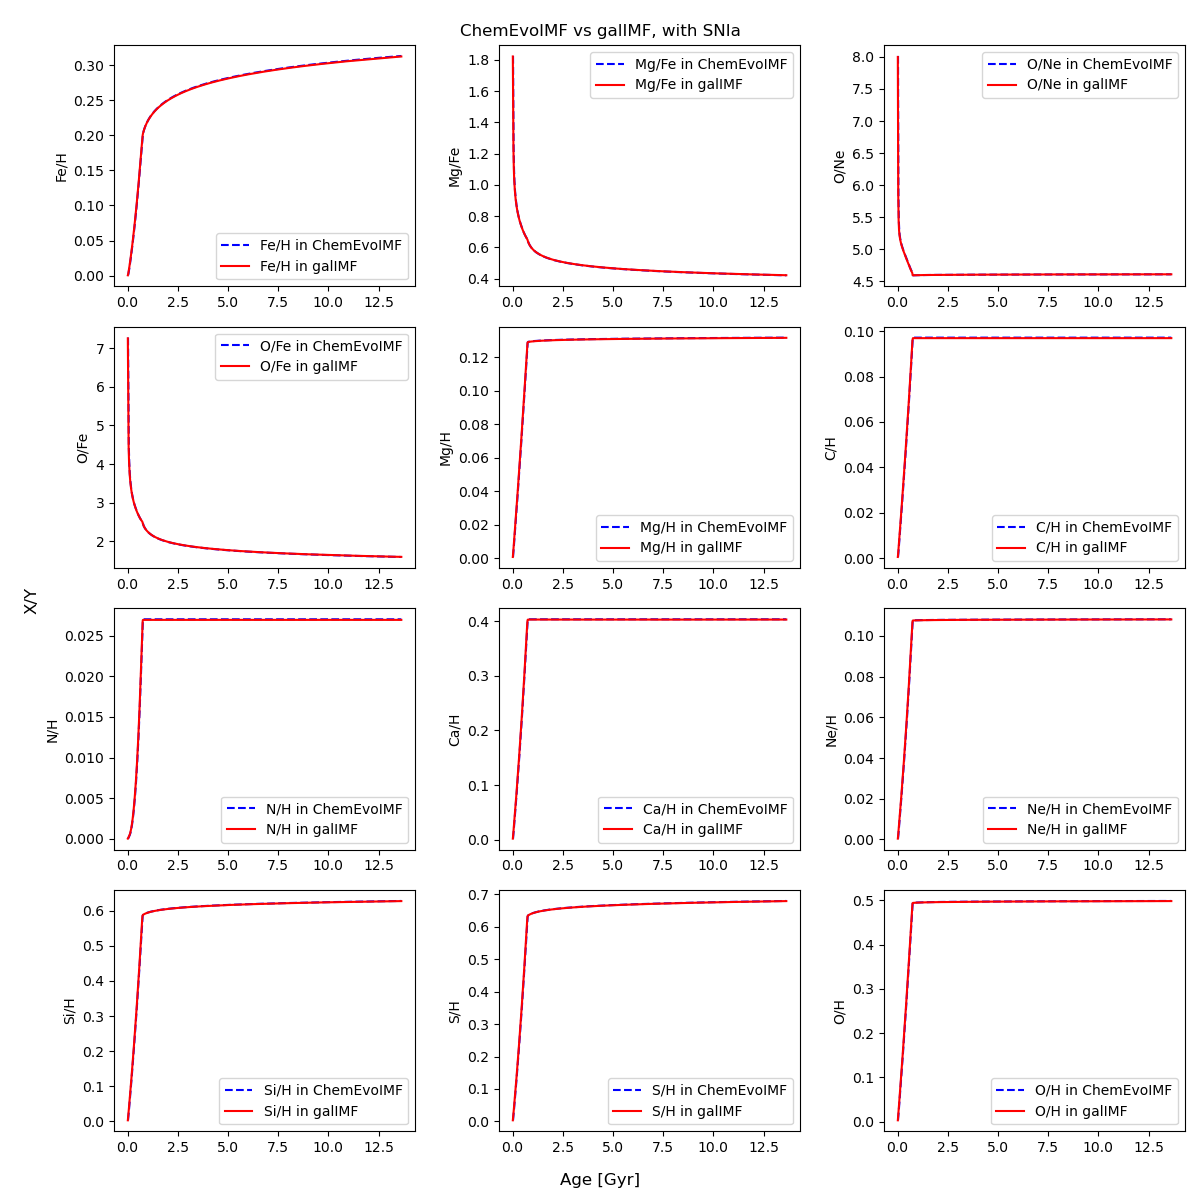

In [4]:
if SNIaOn:
    dir1 = "1square-SNIaON"
else:
    dir1 = "1square-SNIaOFF"

filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(3*4, 4*3))
axes = axes.flatten()
for idx in range(len(Zis)):
    ax = axes[idx]
    Zi = Zis[idx]
    Zj = Zjs[idx]
    correct_factor = constants.abund_tables["AG"][constants.elem_names.index(Zi)]\
        /constants.abund_tables["AG"][constants.elem_names.index(Zj)]\
        *constants.abund_tables[solar_set][constants.elem_names.index(Zj)]\
        /constants.abund_tables[solar_set][constants.elem_names.index(Zi)]
    Zi2Zj = { }
    Zi2Zj["galIMF-%s/%s"%(Zi,Zj)] = 10**np.array(lines[line_num[idx]].split(), dtype=float)*correct_factor
    Zi2Zj.update(GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None))
    ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,Zj)]]/1e9, Zi2Zj['%s/%s'%(Zi,Zj)], 'b--', label='%s/%s in ChemEvoIMF'%(Zi,Zj))
    ax.plot(t/1e9, Zi2Zj["galIMF-%s/%s"%(Zi,Zj)], 'r-', label="%s/%s in galIMF"%(Zi,Zj))
    ax.set_ylabel('%s/%s'%(Zi,Zj))
    ax.legend()

fig.supxlabel('Age [Gyr]')
fig.supylabel('X/Y')

if SNIaOn:
    fig.suptitle("ChemEvoIMF vs galIMF, with SNIa")
    fig.tight_layout()
    fig.savefig("ChemEvoIMF_vs_galIMF_SNIaON.pdf")
else:
    fig.suptitle("ChemEvoIMF vs galIMF, No SNIa")
    fig.tight_layout()
    fig.savefig("ChemEvoIMF_vs_galIMF_SNIaOFF.pdf")
plt.show()

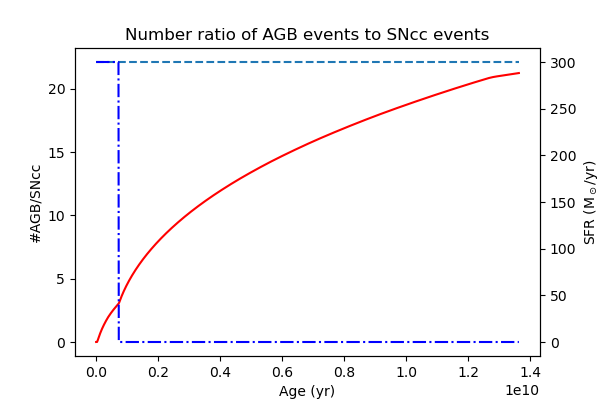

In [5]:
mask = SNccNum.cumsum()>0
imf = IMF(IMF_type=list(IMF_data.keys())[0]).imf
frac = quad(imf, constants.AGB_min, constants.AGB_max)[0] / quad(imf, constants.SNcc_min, constants.SNcc_max)[0]
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(SFH['Age'][mask], AGB_Num.cumsum()[mask]/SNccNum.cumsum()[mask], 'r-', label="ChemEvoIMF")
ax.hlines(frac, SFH['Age'][mask][0], SFH['Age'][mask][-1], linestyles='--', label="Theoretical maximum")
ax1 = ax.twinx()
ax1.plot(SFH['Age'][mask], SFH['SFR'][mask], 'b-.', label="SFR")
ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
ax.set_xlabel("Age (yr)")
ax.set_ylabel("#AGB/SNcc")
ax.set_title("Number ratio of AGB events to SNcc events")
plt.show()

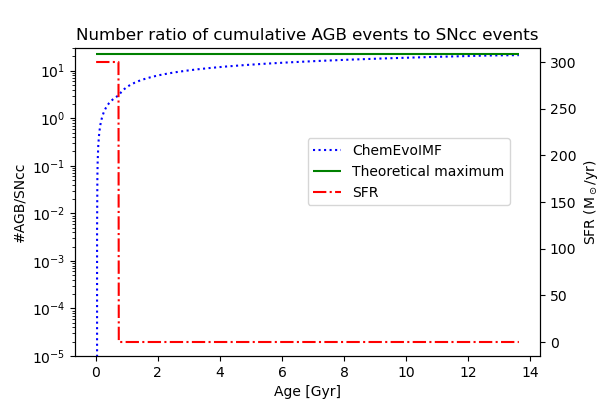

In [6]:
mask = SNccNum.cumsum()>0
imf = IMF(IMF_type=list(IMF_data.keys())[0]).imf
frac = quad(imf, constants.AGB_min, constants.AGB_max)[0] / quad(imf, constants.SNcc_min, constants.SNcc_max)[0]
fig, ax = plt.subplots(figsize=(6, 4))
line1, = ax.plot(SFH['Age'][mask]/1e9, AGB_Num.cumsum()[mask]/SNccNum.cumsum()[mask], 'b:', label="ChemEvoIMF")
line2 = ax.hlines(frac, SFH['Age'][0]/1e9, SFH['Age'][-1]/1e9, linestyles='-', color="green", label="Theoretical maximum")
ax1 = ax.twinx()
line3, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("#AGB/SNcc")
# ax.set_xscale("log")
# ax.set_xlim(0, 14)
ax.set_yscale("log")
ax.set_ylim(1e-5,30)
ax.legend((line1, line2, line3), ("ChemEvoIMF", "Theoretical maximum", "SFR"), loc=(0.5, 0.49), ncol=1)
ax.set_title("Number ratio of cumulative AGB events to SNcc events")
plt.show()

Text(0.5, 0.92, 'The fraction of the cumulative ejected mass from different sources')

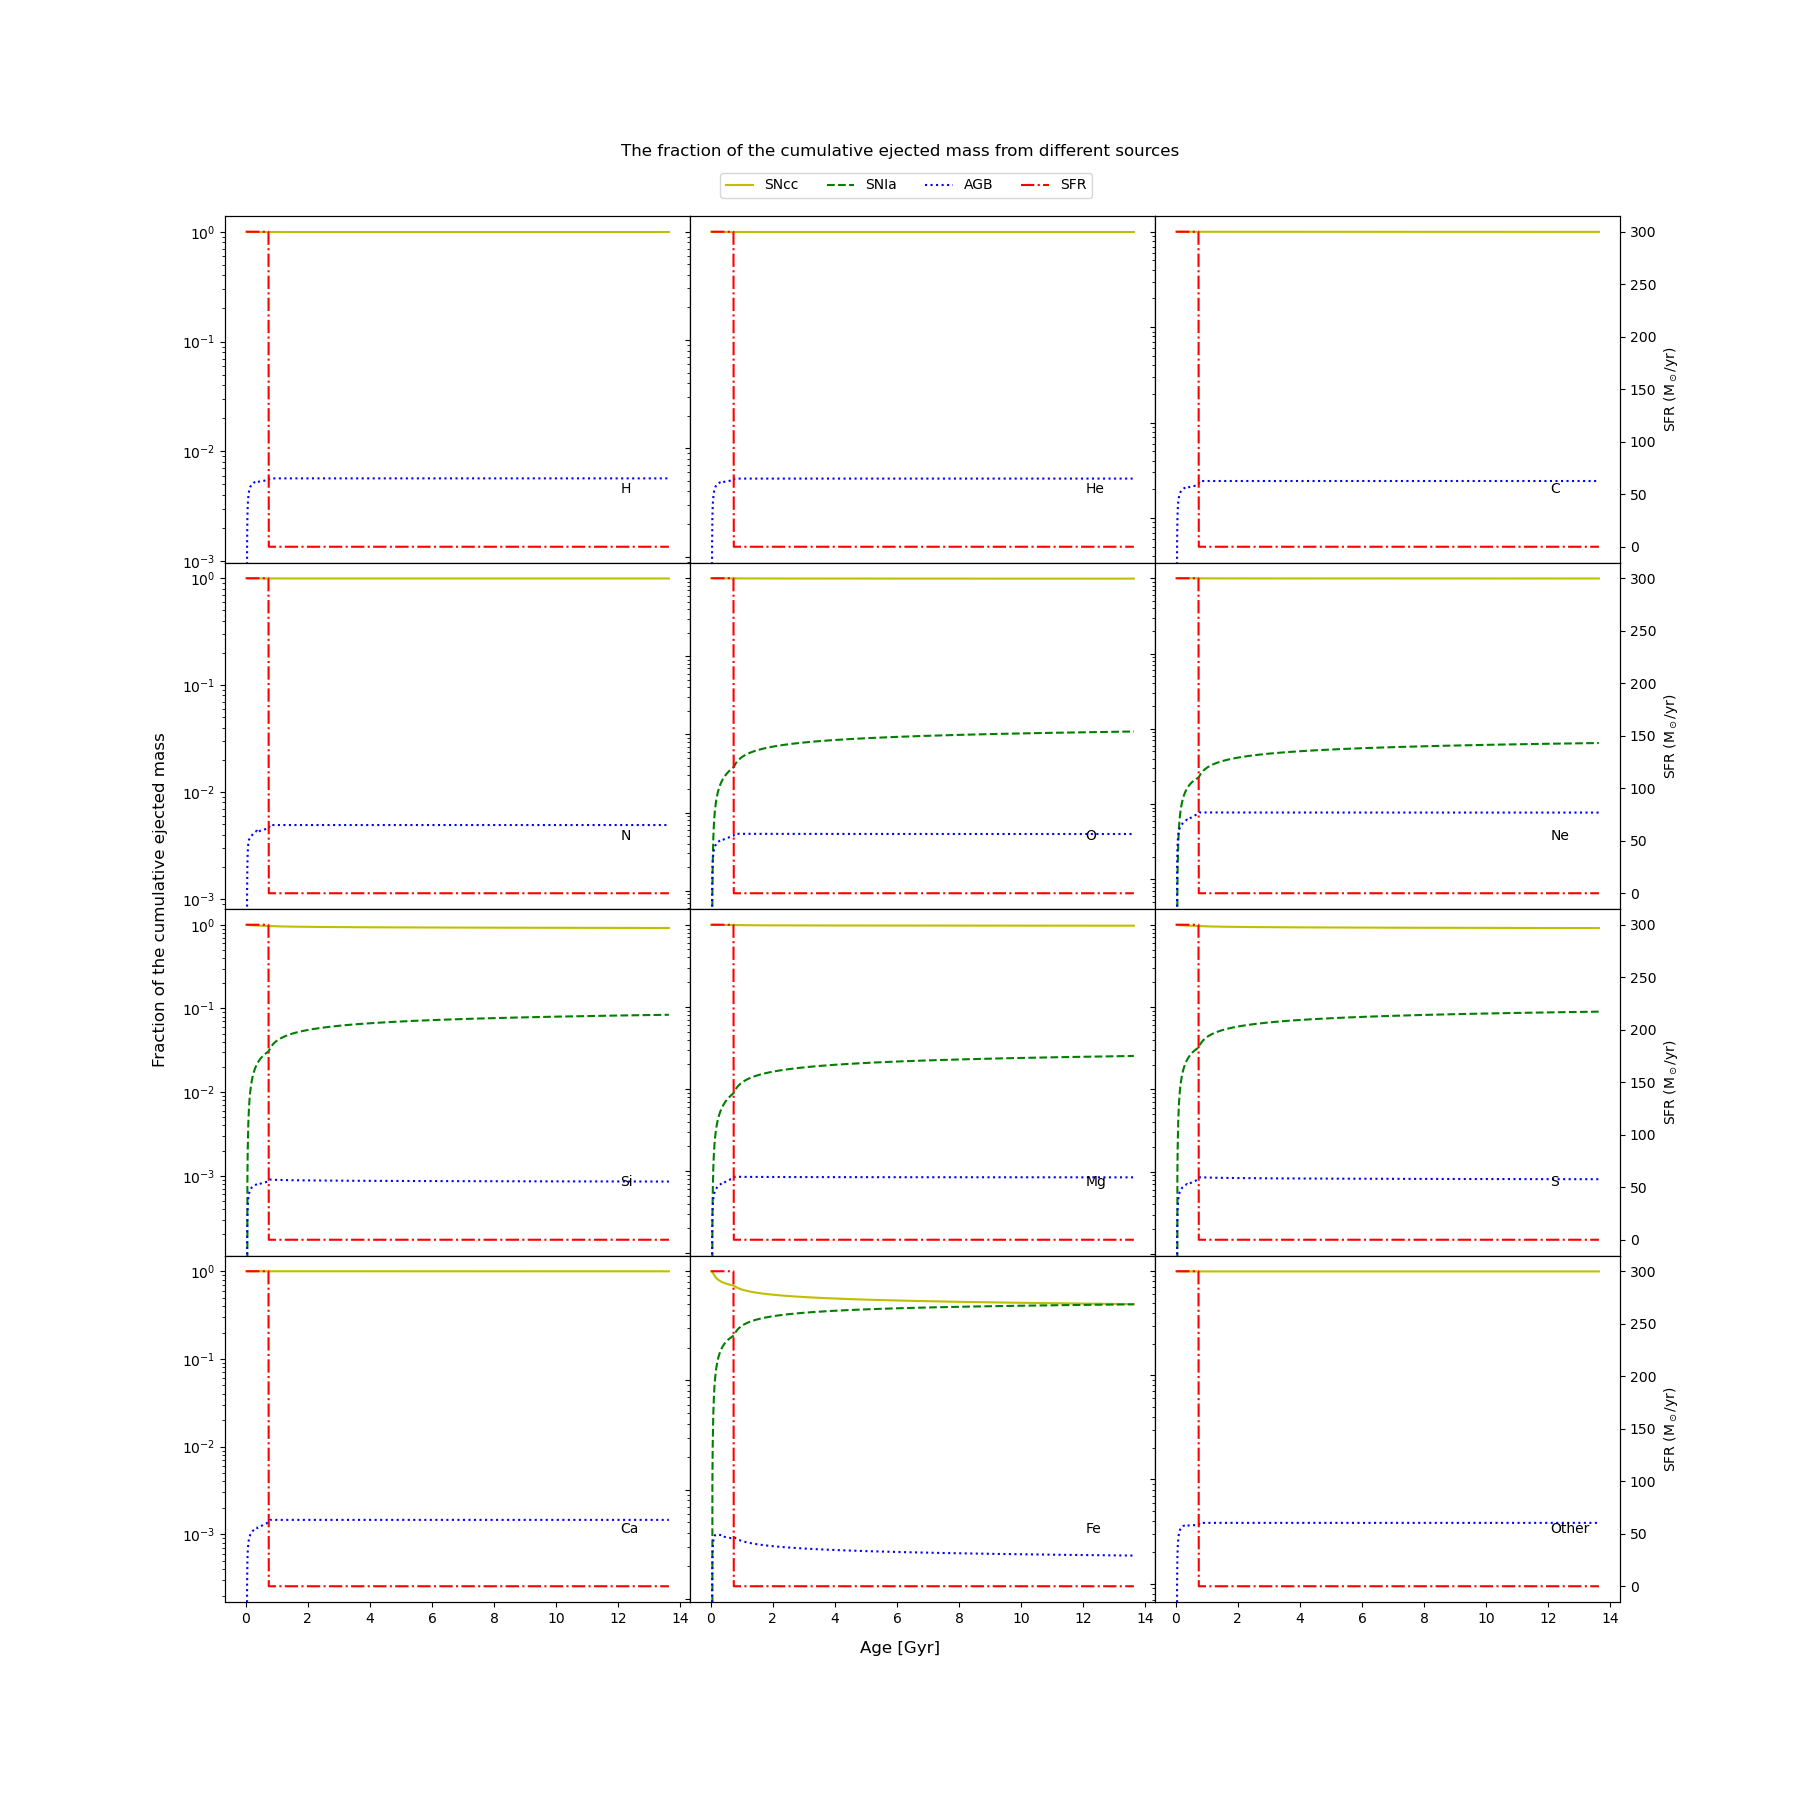

In [8]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
for i, elem in enumerate(ElemNotice):
    ax = fig.add_subplot(gs[i])
    mask = EjectElement[:, constants.elem_names.index(elem)].cumsum()>0
    frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
    frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()\
                /EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()

    line1, = ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, 'y-', markersize=4, label="SNcc")
    line2, = ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, 'g--', markersize=4, label="SNIa")
    line3, = ax.plot(SFH['Age'][mask]/1e9, frac_AGB, 'b:', markersize=4, label="AGB")

    ax1 = ax.twinx()
    line4, = ax1.plot(SFH['Age'][mask]/1e9, SFH['SFR'][mask], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])
    ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
    # ax.set_ylim(1e-5, 2)
    ax.set_yscale('log')
    if i not in [9, 10, 11]:
        ax.set_xticklabels([])
    if i not in [0, 3, 6, 9]:
        ax.set_yticklabels([])
fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel("Fraction of the cumulative ejected mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("SNcc", "SNIa", "AGB", "SFR"), loc=(0.40, 0.89), ncol=4)
fig.suptitle("The fraction of the cumulative ejected mass from different sources", y=0.92)

In [9]:
frac_SNcc

array([1.        , 1.        , 1.        , ..., 0.99617487, 0.99617487,
       0.99617487])

Text(0.5, 0.92, 'The fraction of the instantaneous ejected mass from different sources')

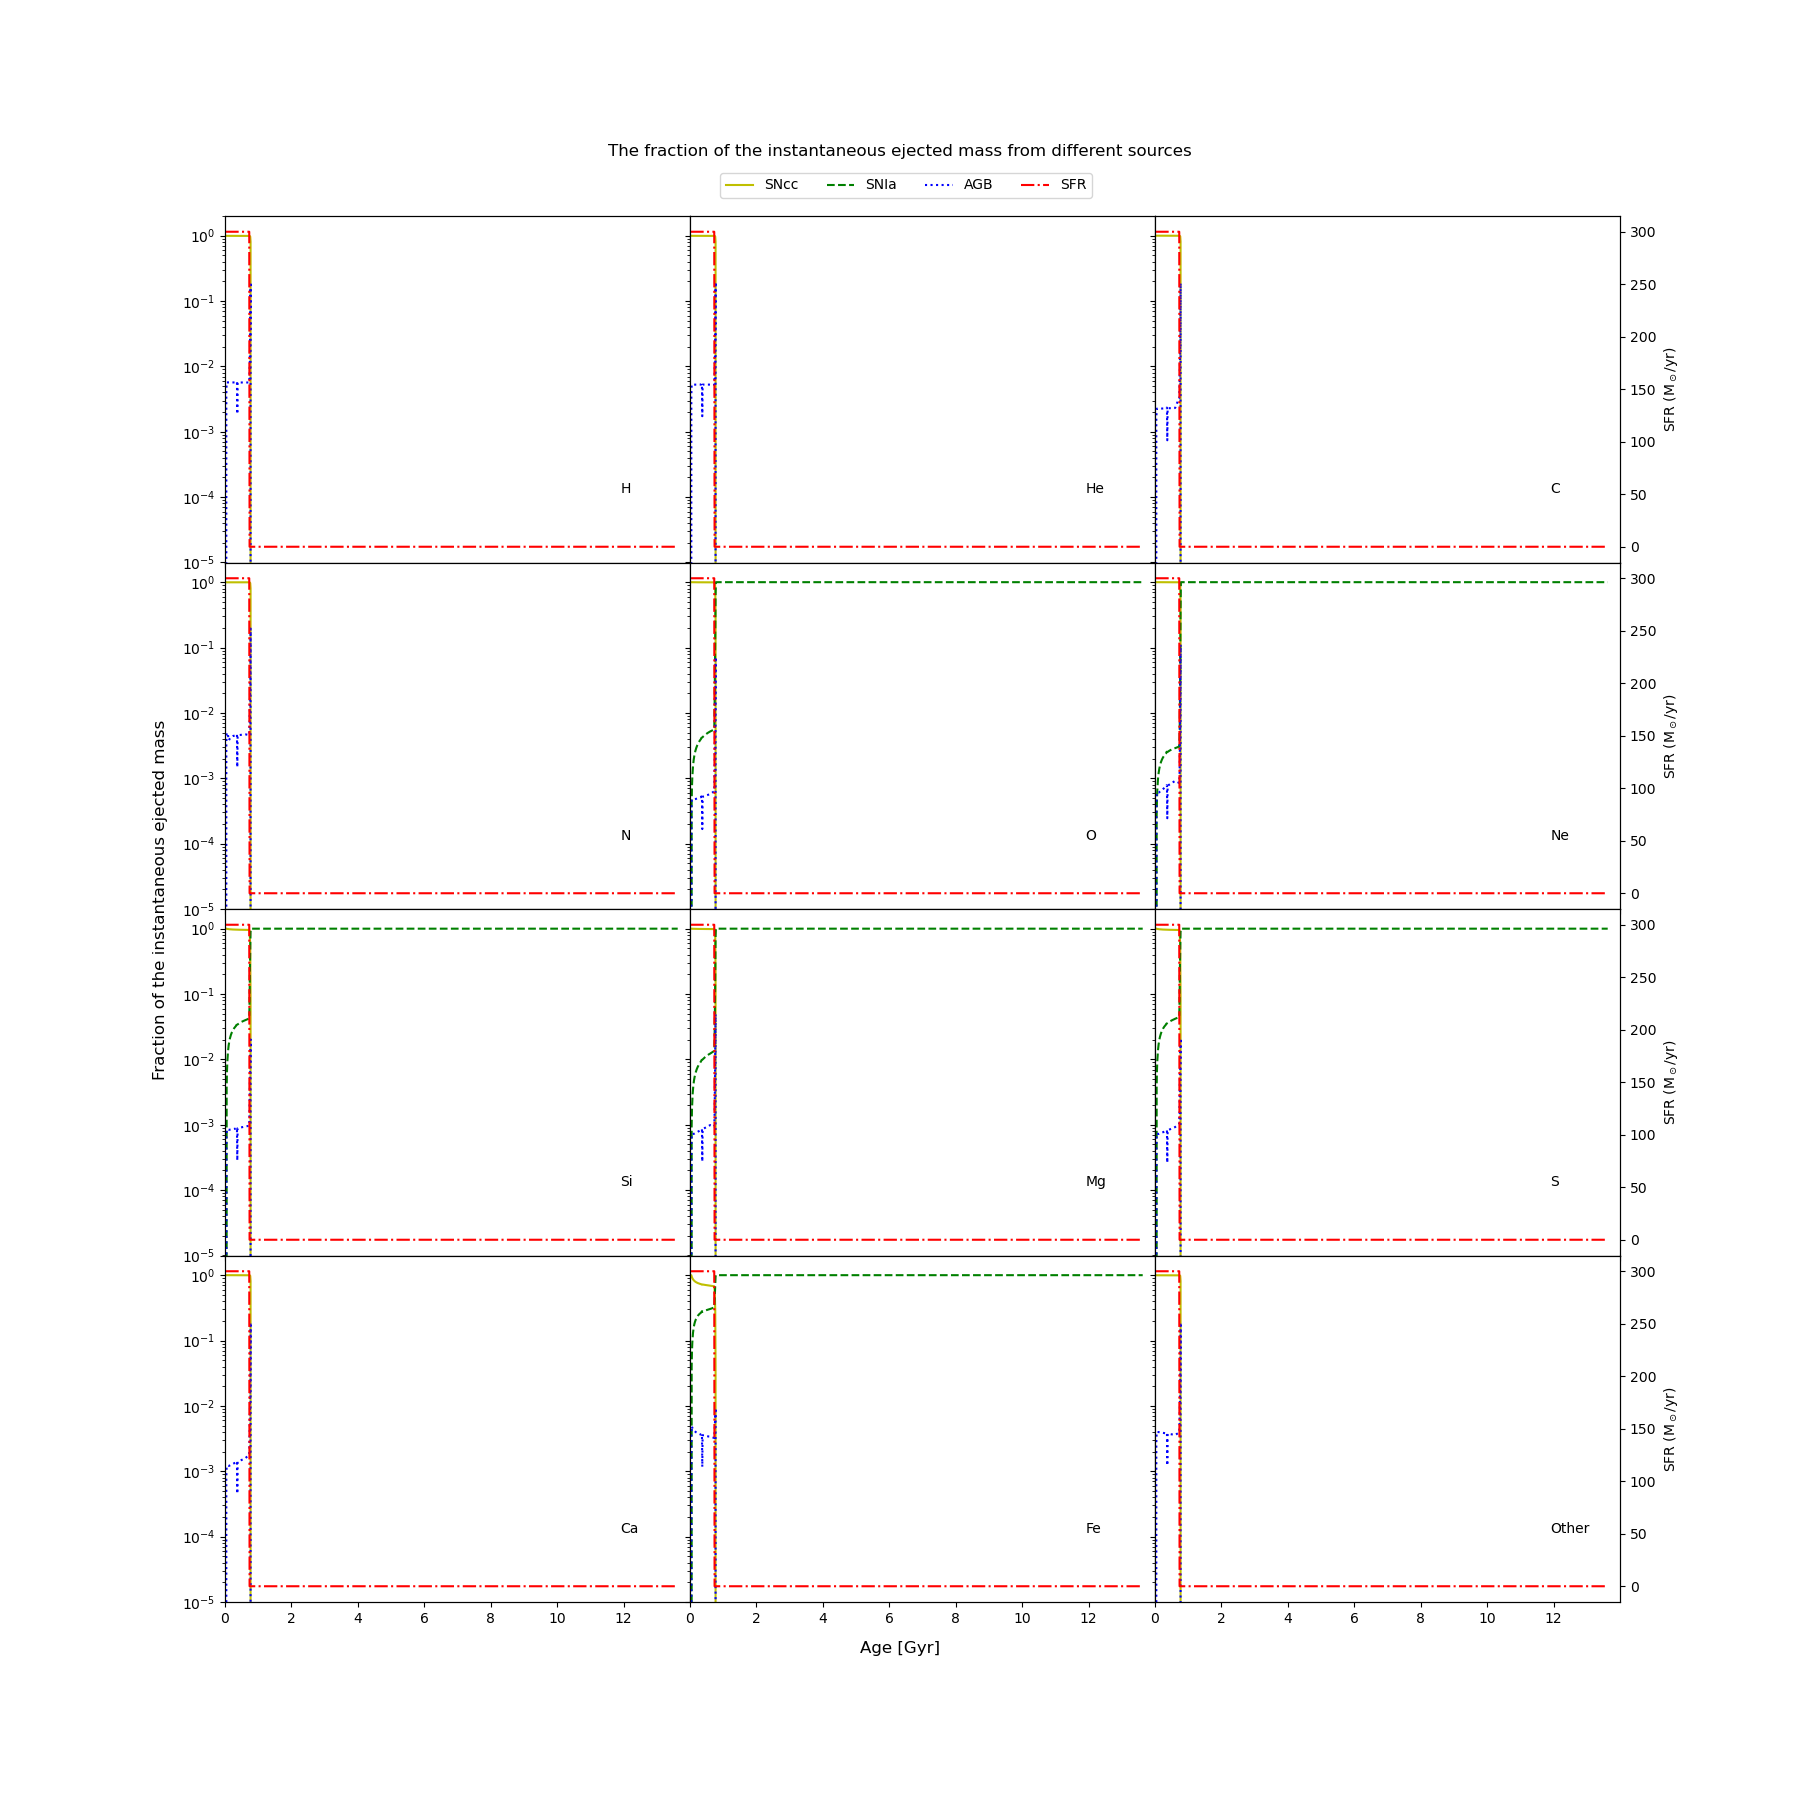

In [10]:
fig = plt.figure(figsize=(6*3, 4.5*4))
# fig.suptitle("Controlling subplot sizes with width_ratios and height_ratios")
gs = GridSpec(4, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1, 1], wspace=0.0, hspace=0.0)
for i, elem in enumerate(ElemNotice):
    ax = fig.add_subplot(gs[i])
    frac_SNIa = np.array([SNIaElement[i, constants.elem_names.index(elem)]/\
                          EjectElement[i, constants.elem_names.index(elem)] \
                          if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    frac_SNcc = np.array([SNccElement[i, constants.elem_names.index(elem)]/\
                          EjectElement[i, constants.elem_names.index(elem)] \
                          if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                            EjectElement[i, constants.elem_names.index(elem)] \
                            if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
    line1, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNcc, 'y-', markersize=4, label="SNcc")
    line2, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNIa, 'g--', markersize=4, label="SNIa")
    line3, = ax.plot(SFH['Age'][:-1]/1e9, frac_AGB, 'b:', markersize=4, label="AGB")
    ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
    ax.set_ylim(1e-5, 2)
    ax.set_yscale('log')
    if i not in [9, 10, 11]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks([0, 2, 4, 6, 8, 10, 12])
    if i not in [0, 3, 6, 9]:
        ax.set_yticklabels([])
    ax.set_xlim(0, 14)
    ax1 = ax.twinx()
    line4, = ax1.plot(SFH['Age']/1e9, SFH['SFR'], 'r-.', label="SFR")
    if i in [2, 5, 8, 11]:
        ax1.set_ylabel(r"SFR (M$_\odot$/yr)")
    else:
        ax1.set_yticklabels([])

fig.supxlabel("Age [Gyr]", y=0.08)
fig.supylabel("Fraction of the instantaneous ejected mass", x=0.085)
fig.legend((line1, line2, line3, line4), ("SNcc", "SNIa", "AGB", "SFR"), loc=(0.40, 0.89), ncol=4)
fig.suptitle("The fraction of the instantaneous ejected mass from different sources", y=0.92)

In [11]:
elem = "Fe"
frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                            EjectElement[i, constants.elem_names.index(elem)] \
                            if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])

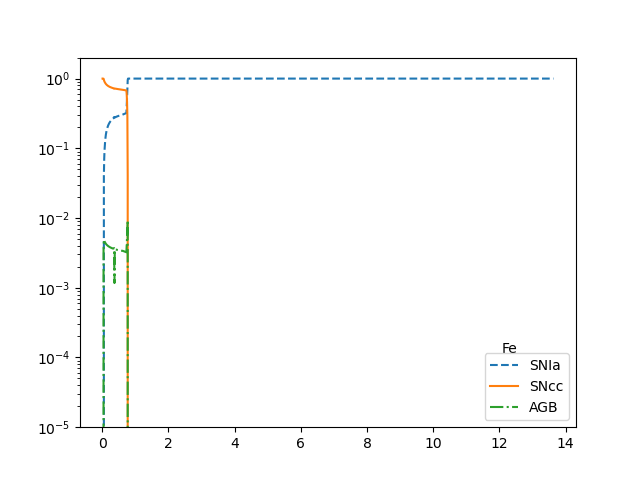

In [12]:
fig, ax = plt.subplots()


elem = "Fe"
frac_SNIa = np.array([SNIaElement[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
frac_SNcc = np.array([SNccElement[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])
frac_AGB = np.array([AGB_Element[i, constants.elem_names.index(elem)]/\
                        EjectElement[i, constants.elem_names.index(elem)] \
                        if EjectElement[i, constants.elem_names.index(elem)]>0 else 0 for i in range(len(SFH['Age'])-1)])


line1, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNIa, '--', markersize=4, label="SNIa")
line2, = ax.plot(SFH['Age'][:-1]/1e9, frac_SNcc, '-', markersize=4, label="SNcc")
line3, = ax.plot(SFH['Age'][:-1]/1e9, frac_AGB, '-.', markersize=4, label="AGB")
ax.annotate(elem, xy=(0.85, 0.2), xycoords='axes fraction')
ax.set_ylim(1e-5, 2)
ax.set_yscale('log')
ax.legend()

In [13]:
2.95+0.73

3.68

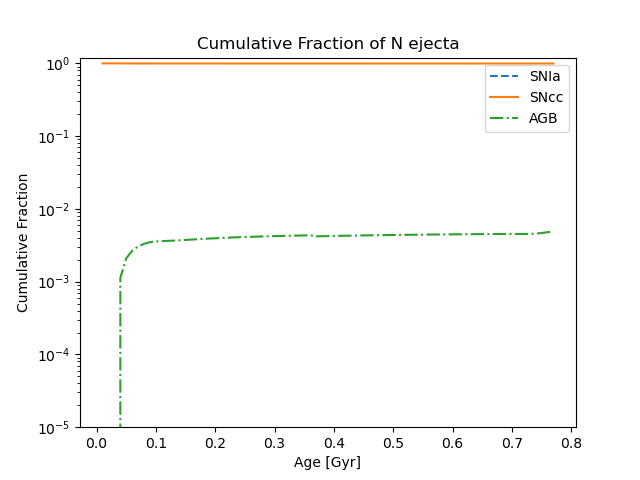

In [14]:
elem = "N"
mask = EjectElement[:, constants.elem_names.index(elem)]>0
frac_SNIa = SNIaElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_SNcc = SNccElement[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
frac_AGB = AGB_Element[:, constants.elem_names.index(elem)][mask].cumsum()/\
            EjectElement[:, constants.elem_names.index(elem)][mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNIa, '--', label="SNIa")
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-', label="SNcc")
ax.plot(SFH['Age'][mask]/1e9, frac_AGB, '-.', label="AGB")
ax.set_ylim(1e-5, 1.2)
ax.set_yscale('log')
ax.legend()
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("Cumulative Fraction")
ax.set_title("Cumulative Fraction of %s ejecta"%elem)
plt.show()

Text(0.5, 0, 'Age [Gyr]')

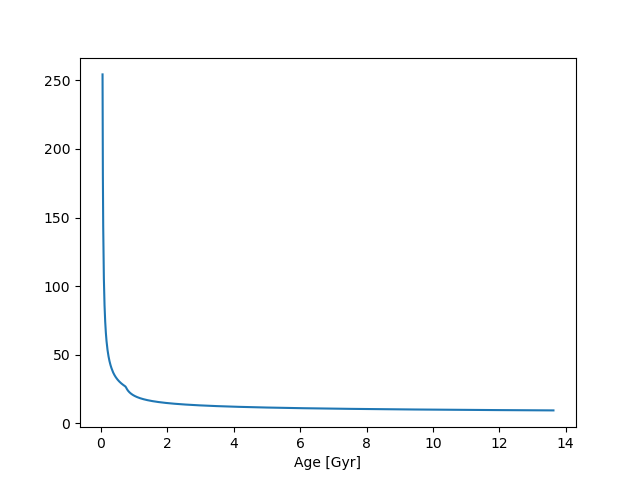

In [15]:
mask = SNIaNum > 0
frac_SNcc = SNccNum[mask].cumsum()/SNIaNum[mask].cumsum()
fig, ax = plt.subplots()
ax.plot(SFH['Age'][mask]/1e9, frac_SNcc, '-')
# ax.set_ylim(0, 1.1)
ax.set_xlabel("Age [Gyr]")

In [24]:
SNccNum

array([ 5779218.40251659, 12428735.16304234, 17829248.67541972, ...,
              0.        ,        0.        ,        0.        ])

[]

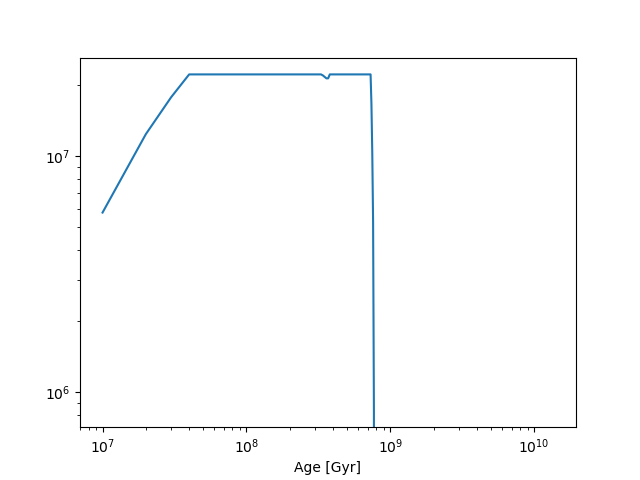

In [28]:
fig, ax = plt.subplots()
ax.plot(SFH['Age'], SNccNum, '-')
# ax.set_ylim(0, 1.1)
ax.set_xlabel("Age [Gyr]")
ax.loglog()

In [8]:
file_path = "../galIMF/yield_tables/rearranged___/setllar_final_mass_from_portinari98/portinari98_Z=0.0004.txt"
with open(file_path, 'r') as f:
    lines = f.readlines()

m_ini = np.array(lines[3].split(), dtype=float)
m_final = np.array(lines[5].split(), dtype=float)

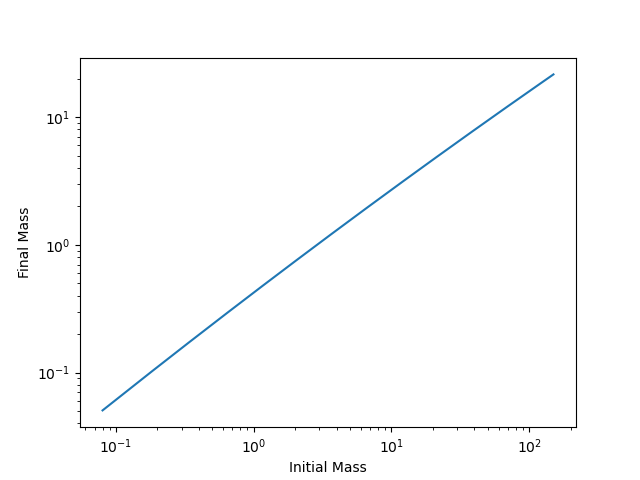

In [12]:
fig, ax = plt.subplots()
ax.plot(m_ini, m_final, '-')
ax.set_xlabel("Initial Mass")
ax.set_ylabel("Final Mass")
ax.set_xscale('log')
ax.set_yscale('log')